# (Complexity and) Topic

In this notebook:
* Visualizing Topic
    * Countplot: how many tweets per topic for each candidate?
    * Tweets per topic during the day for both candidates
* Readability and topic
    * Bar plot with average readability per topic for both candidates
    * Table with per topic: mean, kurtosis and variance of complexity, and mean likes and retweets

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Open Tweets

In [2]:
path_clinton = '../Data/tweets_clinton_20151109_20161109_readability_extrafeatures.json'

with open(path_clinton, encoding="utf8") as f:
    tweets_clinton = pd.read_json(f, orient='columns', convert_axes=True, dtype=True, lines=False)
    
tweets_clinton['created_at'] = tweets_clinton['created_at'].dt.tz_localize(tz='GMT', ambiguous='infer').dt.tz_convert(tz='US/Eastern')

print(tweets_clinton.shape)

(6002, 63)


In [3]:
path_trump = '../Data/tweets_trump_20151109_20161109_readability_extrafeatures.json'

with open(path_trump, encoding="utf8") as f:
    tweets_trump = pd.read_json(f, orient='columns', convert_axes=True, dtype=True, lines=False)
    
tweets_trump['created_at'] = tweets_trump['created_at'].dt.tz_localize(tz='GMT', ambiguous='infer').dt.tz_convert(tz='US/Eastern')

print(tweets_trump.shape)

(4969, 63)


In [4]:
all_tweets = pd.concat([tweets_clinton, tweets_trump], sort=False)

In [5]:
# Seaborn style
sns.set_style("whitegrid")
sns.set_context("talk")

# Colors
my_pal = {"Clinton": "royalblue", "Trump": "orangered"}

In [6]:
def neaten_labels(topics):
    labels = []

    for label in topics:
        label = label.replace('negative', 'neg.')
        label = label.replace('opponent', 'opp.')
        label = label.title() # Start every word with capital character
        label = label.replace('Us ', 'US ')
        label = label.replace("'S ", "'s ")
        labels.append(label)

    return labels

### Lists with all topics

In [7]:
# All topics
topics = all_tweets.topic_hashtag.unique()

In [8]:
# Topics where Trump has more than 20 tweets per topic
topic_trump_count20 = []

for topic, count in tweets_trump.topic_hashtag.value_counts().iteritems():
    if count > 20:
        topic_trump_count20.append(topic)

In [9]:
# Topics where Clinton has more than 20 tweets per topic
topic_clinton_count20 = []

for topic, count in tweets_clinton.topic_hashtag.value_counts().iteritems():
    if count > 20:
        topic_clinton_count20.append(topic)

## Countplot

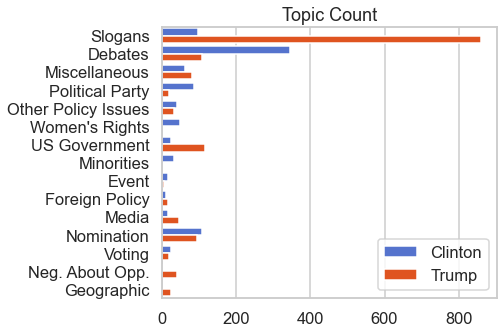

In [10]:
plt.figure(figsize=(6, 5))

a = sns.countplot(
    data = all_tweets[all_tweets['topic_hashtag'] != 'no topic'],
    y = 'topic_hashtag',
    hue = 'user',
    palette = my_pal
).set(
    xlabel = '', 
    ylabel = '',
    title = 'Topic Count'
)

# Remove legend title and change topic labels
plt.legend(title = '', loc = 'lower right')
topics_nono = topics[1:]
plt.yticks(list(range(0, len(topics_nono))), neaten_labels(topics_nono))

plt.savefig('../Plots/countplot_topic.pdf', format = 'pdf', bbox_inches = "tight")

## Topics over time

### During the day

In [11]:
clinton_topic_per_hour = pd.DataFrame()

for topic in topics:
    if topic != '':
        clinton_topic_per_hour[topic] = tweets_clinton[tweets_clinton['topic_hashtag'] == topic]['created_at'].dt.hour.value_counts(sort = True)

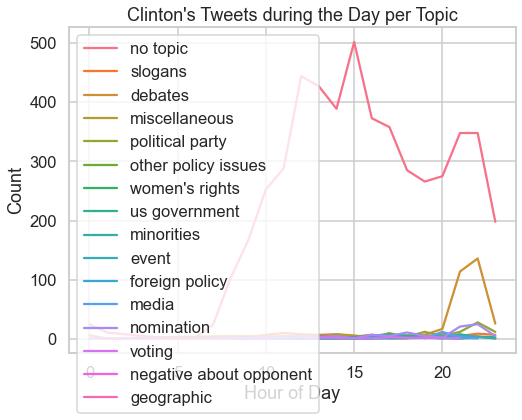

In [12]:
plt.figure(figsize=(8, 6))

# Plot
b = sns.lineplot(
    data = clinton_topic_per_hour,
    dashes = False
).set(
    xlabel = 'Hour of Day', 
    ylabel = 'Count',
    title = "Clinton's Tweets during the Day per Topic"
)

In [13]:
trump_topic_per_hour = pd.DataFrame()

for topic in topics:
    if topic != '':
        trump_topic_per_hour[topic] = tweets_trump[tweets_trump['topic_hashtag'] == topic]['created_at'].dt.hour.value_counts(sort = True)

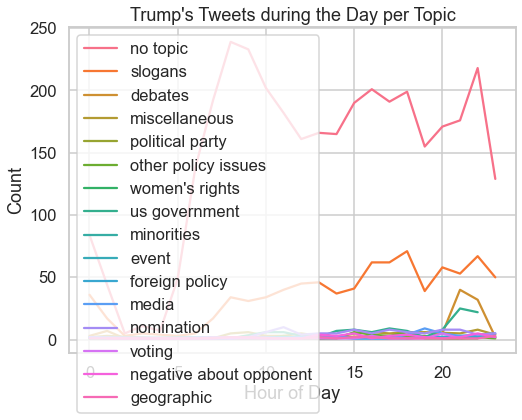

In [14]:
plt.figure(figsize=(8, 6))

# Plot
c = sns.lineplot(
    data = trump_topic_per_hour,
    dashes = False
).set(
    xlabel = 'Hour of Day', 
    ylabel = 'Count',
    title = "Trump's Tweets during the Day per Topic"
)

## Readability per topic

### Trump

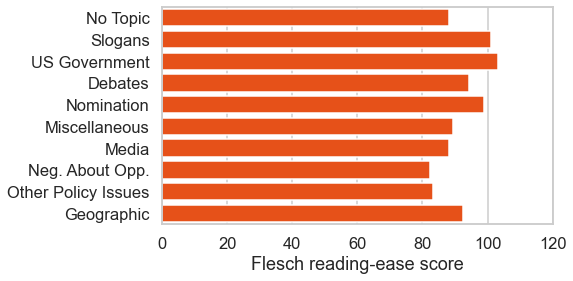

In [15]:
plt.figure(figsize=(7, 4))

# Plot
d = sns.barplot(
    data = tweets_trump,
    x = 'readability grades FleschReadingEase',
    y = 'topic_hashtag',
    order = topic_trump_count20,
    ci = None,
    color = 'orangered',
    saturation = 0.8 #Slightly desaturated looks better
).set(
    xlabel = 'Flesch reading-ease score', 
    ylabel = '',
    title = ''
)

plt.yticks(list(range(0, len(topic_trump_count20))), neaten_labels(topic_trump_count20))

plt.xlim(0, 120)

plt.savefig('../Plots/barplot_readabilitytopic_fre_trump.pdf', format = 'pdf', bbox_inches = "tight")

In [16]:
tweets_trump[tweets_trump['topic_hashtag'] == 'minorities']

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,user,text_clean,readability grades Kincaid,...,day thursday,day friday,day saturday,day sunday,hour of the day,mention trump,mention clinton,mention dem candidate,mention rep candidate,mention obama
2237,iPhone,Happy #CincoDeMayo! The best taco bowls are ma...,2016-05-05 14:57:30-04:00,85465,119759,False,728297587418247168,Trump,Happy # Cinco De Mayo !\nThe best taco bowls a...,-1.06,...,True,False,False,False,18,True,False,False,False,False


In [17]:
def create_means_table(data, topics, readability_score):
    """
    Print latex table with for every topic in the data:
    * Complexity mean, variance and kurtosis
    * Mean like and retweets
    """
    
    table = pd.DataFrame()
    kurtosis = []
    
    # Calculate values for every topic and add to dataframe
    for topic in topics:
        data_topic = data[data['topic_hashtag'] == topic]

        n = data_topic.shape[0]
        mean = int(round(data_topic[readability_score].mean()))
        var = int(round(data_topic[readability_score].var()))
        kurt = round(data_topic[readability_score].kurt(), 2)
        mean_likes = int(round(data_topic['favorite_count'].mean()))
        mean_rts = int(round(data_topic['retweet_count'].mean()))
        
        row = pd.Series([n, mean, var, mean_likes, mean_rts], dtype = 'int')
        kurtosis.append(kurt)
        row_df = pd.DataFrame([row], index = neaten_labels([topic]))
        table = pd.concat([table, row_df])
    
    # Insert kurtosis list into dataframe
    table['Kurtosis'] = kurtosis
    columns = table.columns.tolist()
    columns =  columns[:-3] + ['Kurtosis'] + columns[-3:-1]
    table = table[columns]
        
    # Rename columns
    table = table.rename(columns={0: "N", 1: "Mean", 2: "Variance", 3: 'Likes', 4: 'Retweets'})

    print(table.to_latex(bold_rows = True))
    
    return table

In [18]:
means_table_trump = create_means_table(tweets_trump, topic_trump_count20, 'readability grades FleschReadingEase')

\begin{tabular}{lrrrrrr}
\toprule
{} &     N &  Mean &  Variance &  Kurtosis &  Likes &  Retweets \\
\midrule
\textbf{No Topic           } &  3508 &    88 &       753 &      3.09 &  15779 &      5942 \\
\textbf{Slogans            } &   860 &   101 &       634 &      0.62 &  12838 &      4796 \\
\textbf{US Government      } &   116 &   103 &       638 &      0.57 &  18782 &      9739 \\
\textbf{Debates            } &   107 &    94 &       804 &      1.40 &  14476 &      7447 \\
\textbf{Nomination         } &    95 &    99 &       788 &     -0.47 &   9375 &      3320 \\
\textbf{Miscellaneous      } &    81 &    89 &       840 &      1.02 &  14211 &      5713 \\
\textbf{Media              } &    46 &    88 &       454 &      0.63 &  10633 &      3809 \\
\textbf{Neg. About Opp.    } &    39 &    82 &       940 &      1.50 &  16082 &      7602 \\
\textbf{Other Policy Issues} &    32 &    83 &       642 &      0.24 &  16228 &      7460 \\
\textbf{Geographic         } &    25 &    92 &       

### Clinton

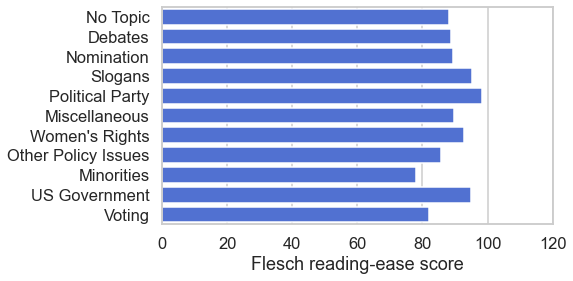

In [20]:
plt.figure(figsize=(7, 4))

# Plot
d = sns.barplot(
    data = tweets_clinton,
    x = 'readability grades FleschReadingEase',
    y = 'topic_hashtag',
    order = topic_clinton_count20,
    ci = None,
    color = 'royalblue',
    saturation = 0.8 #Slightly desaturated looks better
).set(
    xlabel = 'Flesch reading-ease score', 
    ylabel = '',
    title = ''
)

plt.yticks(list(range(0, len(topic_clinton_count20))), neaten_labels(topic_clinton_count20))

plt.xlim(0, 120)

plt.savefig('../Plots/barplot_readabilitytopic_fre_clinton.pdf', format = 'pdf', bbox_inches = "tight")

In [21]:
tweets_clinton[tweets_clinton['topic_hashtag'] == 'negative about opponent']

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,user,text_clean,readability grades Kincaid,...,day thursday,day friday,day saturday,day sunday,hour of the day,mention trump,mention clinton,mention dem candidate,mention rep candidate,mention obama
3543,TweetDeck,RT @UAW: .@realDonaldTrump has an economic pla...,2016-08-08 13:50:47-04:00,695,0,True,762707643488202752,Clinton,RT @ UAW : . @ real Donald Trump has an econom...,6.085714,...,False,False,False,False,17,True,False,False,False,False


In [22]:
means_table_clinton = create_means_table(tweets_clinton, topic_clinton_count20, 'readability grades FleschReadingEase')

\begin{tabular}{lrrrrrr}
\toprule
{} &     N &  Mean &  Variance &  Kurtosis &  Likes &  Retweets \\
\midrule
\textbf{No Topic           } &  5093 &    88 &       571 &      1.45 &   5235 &      2667 \\
\textbf{Debates            } &   345 &    89 &       747 &      1.79 &   9037 &      4983 \\
\textbf{Nomination         } &   107 &    89 &       389 &      0.43 &   1988 &      1017 \\
\textbf{Slogans            } &    98 &    95 &       536 &      0.57 &   2013 &      2199 \\
\textbf{Political Party    } &    85 &    98 &       528 &     -0.05 &   5586 &      3126 \\
\textbf{Miscellaneous      } &    62 &    90 &       579 &      0.10 &   3766 &      2343 \\
\textbf{Women's Rights     } &    47 &    93 &       505 &      1.80 &   5603 &      3020 \\
\textbf{Other Policy Issues} &    41 &    86 &       492 &      0.25 &   2930 &      1743 \\
\textbf{Minorities         } &    31 &    78 &       752 &     -0.54 &   4876 &      3050 \\
\textbf{US Government      } &    25 &    95 &       